## Module d'apprentissage basé sur la proportion de bleu dans des plages de valeurs d'intensité des pixels

Exemple : pour une plage = 50, nos plages seront 0-50 50-100 100-150..

In [2]:
import os
from PIL import Image
import matplotlib.pyplot as plt

path_mer = 'Data/Mer/'
path_ailleurs = 'Data/Ailleurs/'
step = 25

def get_image_data(img_path, reds=True, greens=True, blues=True, width=True, Height=True):
    '''
    Récupérer les données de l'image. On retourne un tuple contenant:
    0 : liste pixels rouges
    1 : "     "      verts
    2 : "     "      bleus
    3, 4: width, height
    '''
    img = Image.open(img_path)
    img = img.convert('RGB')
    w = img.width
    h = img.height
    r_, g_, b_ = img.split()
    return (r_.histogram(), g_.histogram(), b_.histogram(), w, h)

In [3]:
def blue_intensity_proportions(images_path, step):
    '''
    Cette fonction retourne un dictionnaire {nom : liste(proportions)} pour toutes les images localisées dans le répertoire images_path.
    Pour connaître la length des listes contenant les proportions, on peut faire (255 // step).
    '''
    proportions = {}

    for file in os.listdir(images_path):
        r, g, b = get_image_data(images_path + file)[:3]
        props = []
        nb_blues_tot = 0
        nb_blues_step = 0
        current_step = step

        for intensity in range(255):
            if intensity > current_step and intensity + step < 255:
                props.append(nb_blues_step)
                current_step += step
                nb_blues_step = 0
            nb_blues_step += b[intensity]
            nb_blues_tot += b[intensity]
        props.append(nb_blues_step)
        proportions[file] = [prop / nb_blues_tot for prop in props]

    return proportions

# On calcule les proportions moyennes afin de visualiser la différence entre les photos dans le dossier mer et celles dans le dossier ailleurs
def get_average_blue_intensity_proportions(images_path, step):
    proportions = blue_intensity_proportions(images_path, step)
    nb_values = len(proportions)
    props_length = 255 // step
    average_props = [0 for _ in range(props_length)]

    for img in proportions:
        props = proportions[img]
        for i in range(props_length):
             average_props[i] += props[i]
    
    return [avg_prop / nb_values for avg_prop in average_props]

## (i) Calcul des proportions pour chaque images

In [5]:
avg_props_mer = get_average_blue_intensity_proportions(path_mer, step)
avg_props_ailleurs = get_average_blue_intensity_proportions(path_ailleurs, step)

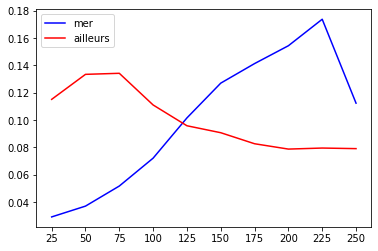

In [7]:
# Visualisation

intensities =  [step * (i + 1) for i in range(255 // step)]

plt.plot(intensities, avg_props_mer, '-b', label='mer')
plt.plot(intensities, avg_props_ailleurs, '-r', label='ailleurs')

plt.xticks(intensities)

plt.legend();

## (ii) Phase d'apprentissage

In [8]:
X = []
y = []
proportions_mer =  blue_intensity_proportions(path_mer, step)
proportions_ailleurs = blue_intensity_proportions(path_ailleurs, step)
for img in proportions_mer.keys():
    X.append(proportions_mer[img])
    y.append(1)
for img in proportions_ailleurs.keys():
    X.append(proportions_ailleurs[img])
    y.append(0)

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
classifieur = GaussianNB()

average_accuracy = 0
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
    classifieur.fit(X_train, y_train)
    y_predits = classifieur.predict(X_test)
    average_accuracy += accuracy_score(y_test, y_predits)
average_accuracy /= 50
print(average_accuracy)

0.7727710843373492
